In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Pengaturan Global
SEED = 2026
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

if os.path.exists('/kaggle/input/house-prices-advanced-regression-techniques/train.csv'):
    TRAIN_PATH = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
    TEST_PATH = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
    print("Environment: Kaggle Detected")
else:
    TRAIN_PATH = 'data/train.csv'
    TEST_PATH = 'data/test.csv'
    print("Environment: Local Detected")

# Pengaturan Visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Setup Selesai. Siap menganalisis data dengan SEED: {SEED}")

Environment: Kaggle Detected
Setup Selesai. Siap menganalisis data dengan SEED: 2026


In [2]:
df_train = pd.read_csv(TRAIN_PATH)
df_train.head()
df_train.shape
df_train.info()
df_train.describe()
df_train.isnull().sum().sort_values(ascending=False).head(20)
df_train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Text(0.5, 1.0, 'Distribusi Harga Rumah')

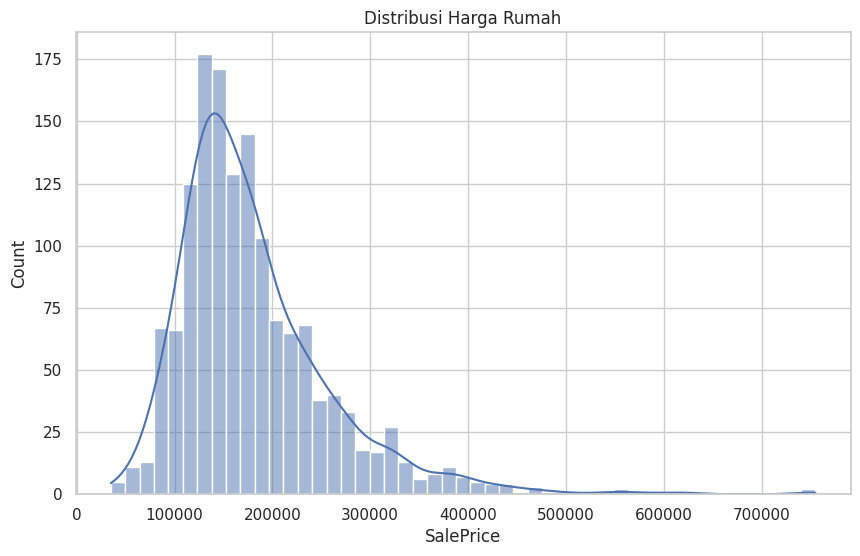

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('Distribusi Harga Rumah')

Text(0.5, 1.0, 'Hubungan Kualitas Bangunan terhadap Harga')

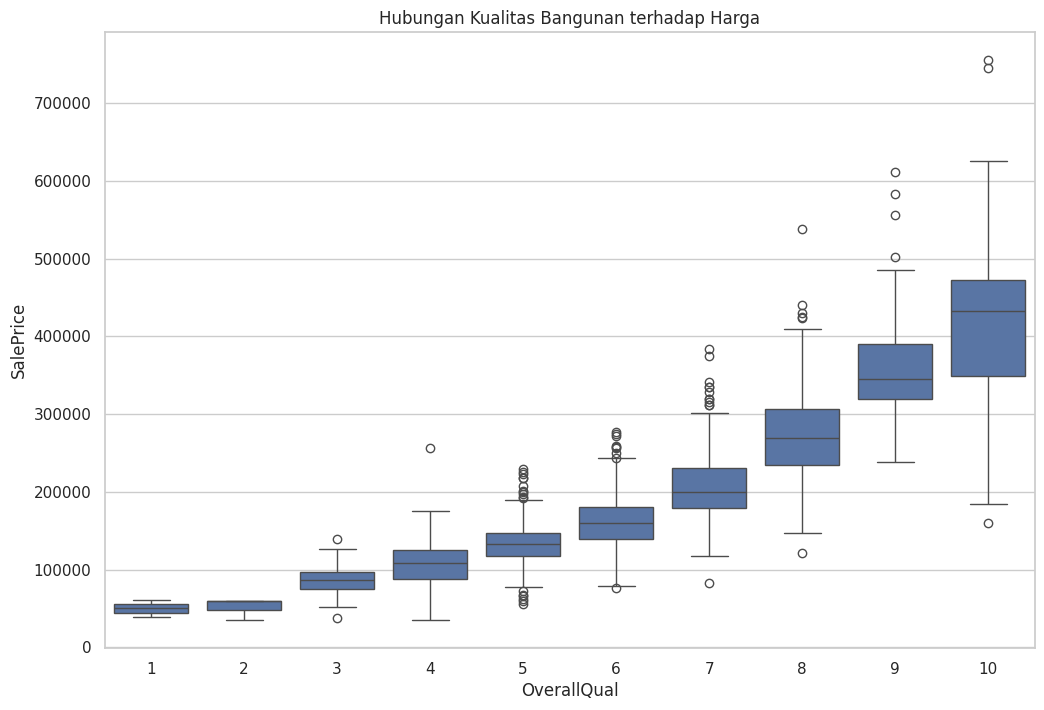

In [4]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)
plt.title('Hubungan Kualitas Bangunan terhadap Harga')

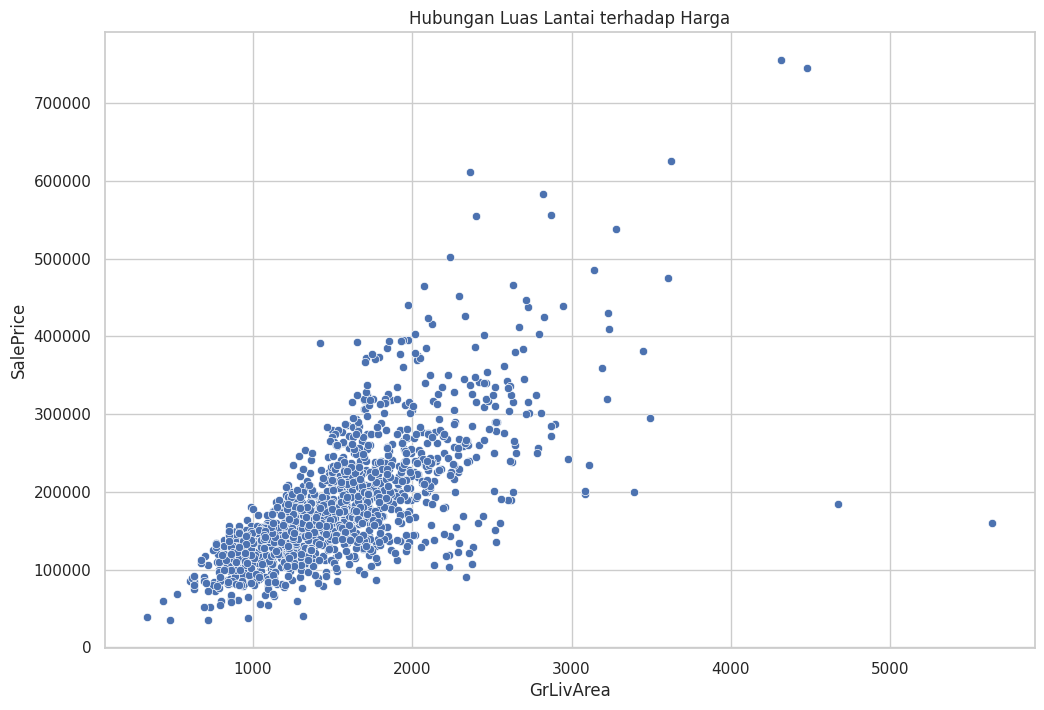

In [5]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.title('Hubungan Luas Lantai terhadap Harga')
plt.show()

Menghapus Outlier

In [6]:
outliers = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)]
print(outliers.index)

df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.reset_index(drop=True)

Index([523, 1298], dtype='int64')


Data Cleaning (Pembersihan Data)

In [7]:
ntrain = df_train.shape[0]
df_test = pd.read_csv(TEST_PATH)

y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
features_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
for col in features_none: all_data[col] = all_data[col].fillna('None')

# 1. Grup Garasi (Angka) 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# 2. Grup Garasi (Teks) 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# 3. Grup Basement (Angka) 
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# 4. Grup Basement (Teks) 
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

print(all_data.isnull().sum().sort_values(ascending=False).head(10))

MasVnrType     1766
LotFrontage     486
MasVnrArea       23
MSZoning          4
Utilities         2
Functional        2
Exterior1st       1
Electrical        1
Exterior2nd       1
KitchenQual       1
dtype: int64


In [8]:
# 1. MasVnr (Tembok Batu)
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# 2. MSZoning (Isi dengan yang paling sering muncul / Modus)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# 3. LotFrontage (Isi dengan median per tetangga/neighborhood)
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 4. Sisa fitur printilan (Isi dengan Modus atau Default)
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['Functional'] = all_data['Functional'].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])


print(all_data.isnull().sum().max())

0


In [11]:
# Mengubah angka menjadi string 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [12]:
from sklearn.preprocessing import LabelEncoder

# Daftar kolom yang punya urutan kualitas
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Proses mengubah teks menjadi angka berurutan 0, 1, 2, dst
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 80)


In [13]:
# Menjumlahkan seluruh luas area 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

print("Super Feature 'TotalSF' berhasil dibuat.")

Super Feature 'TotalSF' berhasil dibuat.


In [14]:
from scipy.stats import skew
from scipy.special import boxcox1p

# 1. Cari kolom yang isinya angka (bukan kategori)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 2. Hitung kemiringan (skewness) setiap kolom
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# 3. Ambil kolom yang kemiringannya parah (di atas 0.75)
skewness = skewed_feats[abs(skewed_feats) > 0.75]
print(f"Ada {len(skewness)} fitur yang miring dan akan diperbaiki.")

# 4. Perbaiki data miring tersebut dengan Box-Cox Transformation
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print("Data angka sudah dinormalkan.")

Ada 36 fitur yang miring dan akan diperbaiki.
Data angka sudah dinormalkan.
